## Produce the power spectrum of a time series of events

Version 1.0

10.11.2020

M.R. Fitzsimmons



## The notebook loads single event mode data and processes the data to yield the power spectrum
This notebook requires NumPy event mode data files (event data and metadata log). Only the "Off_Off" data are analyzed.  These files can be obtained
using the BL4A_get_single_event_... Jupyter notebook* applied to user-data, or the example files can be used.  This Jupyter
notebook does not require Mantid code, so a Python 3 kernal can be used. The code was designed for data recorded at FTS
with 1 ns accuracy.  The code uses uint64 representations to perserve the ns-accuracy.

    1) Loads binary numpy-written files including the detector data and the slow log data. The input data should be in a sub-directory called "/input" of the working directory. The results are written to the working directory.
    2) Calculate the power spectrum, plot it and write it. 
    
*T.R. Charlton and M.R. Fitzsimmons, Code to obtain single event data from Spallation Neutron Source Beamline-4A (MagRef) (2020) https://doi.org/10.5281/zenodo.3967680
    

## Required user input (indicated by "USER INPUT HERE")
    1) Assign directory path. 
    2) Identify run number(s) for the data file(s) (e.g., a run number or list of numbers)
    3) Choose whether or not to normalize the data by the number of events squared.
    4) Choose the number of frequency bins and the maximum frequency to calculate the power spectrum.

In [4]:
# Suppress autoscrolling in notebook, otherwise try Cell>All Output>Toggle Scrolling
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

directory_path = cwd_path+r'/Dropbox (ORNL)/Neutron Scattering/CW Approach/AutoC/' # USER INPUT HERE

run_numbers = ['36252','36546','36547','36548','36556','36557','36558'] # 1st 4 dbp last 3 rbp

# Note the input data should be in a sub directory of the working directory called "input"

Normalize = False # USER INPUT HERE will not normalize
Normalize = True # will normalize by NEvents^2

fBins = 2001 # USER INPUT HEREnumber of frequency bins to calculate
Maxf = fBins - 1 # USER INPUT HERE maximum frequency to calculate (Hz), range is 0 to Maxf


/Users/mf3
Current working directory: /Users/mf3


## Import libraries and define functions

In [5]:
import numpy as np
#import numpy.ma as ma 
#from numpy.linalg import inv
np.warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy.constants 
from scipy import signal
#import copy
from datetime import datetime

# get physical constants from scipy library
Pi = scipy.constants.pi

# Function returns string corresponding to flippers states condition.
def index_to_state(argument):
    inv_states = {
        0: 'Off_Off',
        1: 'On_Off',
        2: 'Off_On',
        3: 'On_On'
    }
    return inv_states.get(argument, "invalid") 

# Function returns index corresponding to flippers states condition string.
def state_to_index(argument):
    states_inv = {
        'Off_Off': 0,
        'On_Off': 1,
        'Off_On': 2,
        'On_On': 3
    }
    return states_inv.get(argument, "invalid") 

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx


def load_some_data(Input_File_Base):
    active_spin_states = np.zeros(4,dtype=np.int8)
    
    t0_time_Off_Off = 0
    t0_time_string_Off_Off = 0
    tof_Off_Off = 0
    pixel_id_Off_Off = 0
    pcharge_Off_Off = 0

    t0_time_On_Off = 0
    t0_time_string_On_Off = 0
    tof_On_Off = 0
    pixel_id_On_Off = 0
    pcharge_On_Off = 0

    t0_time_Off_On = 0
    t0_time_string_Off_On = 0
    tof_Off_On = 0
    pixel_id_Off_On = 0
    pcharge_Off_On = 0

    t0_time_On_On = 0
    t0_time_string_On_On = 0
    tof_On_On = 0
    pixel_id_On_On = 0
    pcharge_On_On = 0   

    for i in range(4):
        s_state_descriptor = index_to_state(i)
        try:
#            print('Fetching: %s'%s_state_descriptor)
            data = np.load(Input_File_Base+s_state_descriptor+'.npz')
            active_spin_states[i] = 1
            if i == 0:
                t0_time_Off_Off = data['arr_0']
                t0_time_string_Off_Off = data['arr_1']
                tof_Off_Off = data['arr_2']
                pixel_id_Off_Off = data['arr_3']
                pcharge_Off_Off = data['arr_4']
            if i == 1:
                t0_time_On_Off = data['arr_0']
                t0_time_string_On_Off = data['arr_1']
                tof_On_Off = data['arr_2']
                pixel_id_On_Off = data['arr_3']
                pcharge_On_Off = data['arr_4']
            if i == 2:
                t0_time_Off_On = data['arr_0']
                t0_time_string_Off_On = data['arr_1']
                tof_Off_On = data['arr_2']
                pixel_id_Off_On = data['arr_3']
                pcharge_Off_On = data['arr_4']
            if i == 3:
                t0_time_On_On = data['arr_0']
                t0_time_string_On_On = data['arr_1']
                tof_On_On = data['arr_2']
                pixel_id_On_On = data['arr_3']
                pcharge_On_On = data['arr_4']    
        except IOError:
                a=1
#            print('No '+s_state_descriptor+' data found.')
            
# slow log

    data = np.load(Input_File_Base+'log.npz')
    pixel_to_coordinate=data['arr_0']
    Source_Sample_Distance=data['arr_1']
    Sample_Detector_Center_Distance=data['arr_2']
    TemperatureLog_times=data['arr_3']
    TemperatureLog_value=data['arr_4']
    DANGLELog_times=data['arr_5']
    DANGLELog_value=data['arr_6']
    DANGLE0Log_times=data['arr_7']
    DANGLE0Log_value=data['arr_8']
    SANGLELog_times=data['arr_9']
    SANGLELog_value=data['arr_10']
    C0Log_times=data['arr_11']
    C0Log_value=data['arr_12']
    ChopperFreqLog_times=data['arr_13']
    ChopperFreqLog_value=data['arr_14']
    LambdaBarLog_times=data['arr_15']
    LambdaBarLog_value=data['arr_16']
    EMagLog_times=data['arr_17']
    EMagLog_value=data['arr_18']
    
    all_data= [active_spin_states,\
               t0_time_Off_Off,t0_time_string_Off_Off,tof_Off_Off,pixel_id_Off_Off,pcharge_Off_Off, \
               t0_time_On_Off,t0_time_string_On_Off,tof_On_Off,pixel_id_On_Off,pcharge_On_Off, \
               t0_time_Off_On,t0_time_string_Off_On,tof_Off_On,pixel_id_Off_On,pcharge_Off_On, \
               t0_time_On_On,t0_time_string_On_On,tof_On_On,pixel_id_On_On,pcharge_On_On]   

    all_log = [pixel_to_coordinate,Source_Sample_Distance,Sample_Detector_Center_Distance, \
              TemperatureLog_times,TemperatureLog_value,DANGLELog_times,DANGLELog_value, \
              DANGLE0Log_times,DANGLE0Log_value,SANGLELog_times,SANGLELog_value,C0Log_times, \
              C0Log_value,ChopperFreqLog_times,ChopperFreqLog_value,LambdaBarLog_times,\
              LambdaBarLog_value,EMagLog_times,EMagLog_value]
    return all_data,all_log


## Begin processing of many files

Run numbers to be processed:
['36252', '36546', '36547', '36548', '36556', '36557', '36558']
Run Number: 36252
2Theta angle: -0.01 (0.00)
Number of events: 5691706
Total exposure time (s): 2608.267952
Count rate: 2182.178405265319


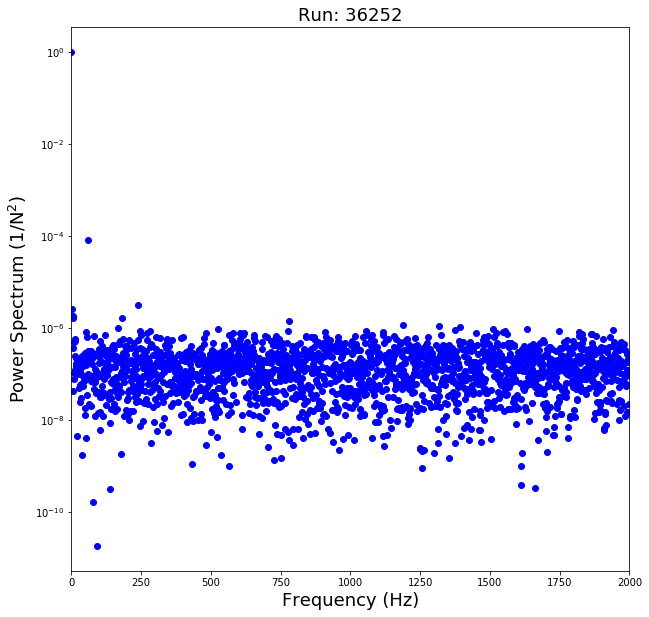

Run Number: 36546
2Theta angle: -0.01 (-0.01)
Number of events: 1482877
Total exposure time (s): 234.19870730000002
Count rate: 6331.704461974201


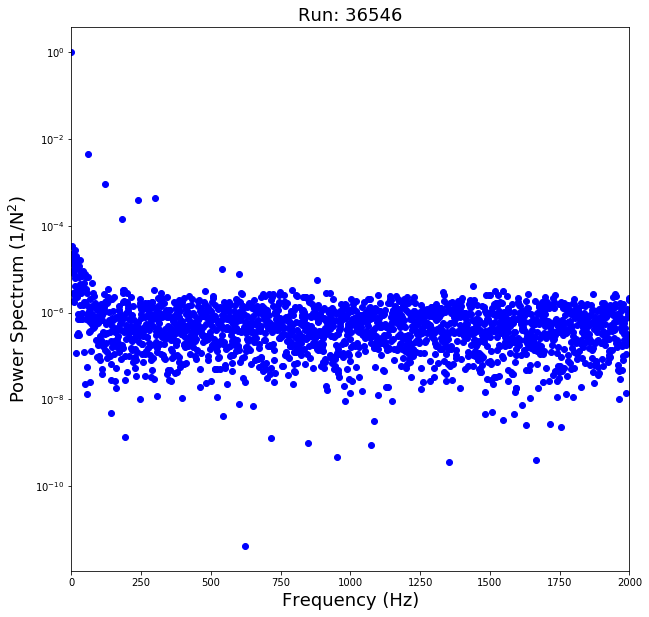

Run Number: 36547
2Theta angle: -0.01 (-0.01)
Number of events: 1788690
Total exposure time (s): 424.37252370000004
Count rate: 4214.9053016082435


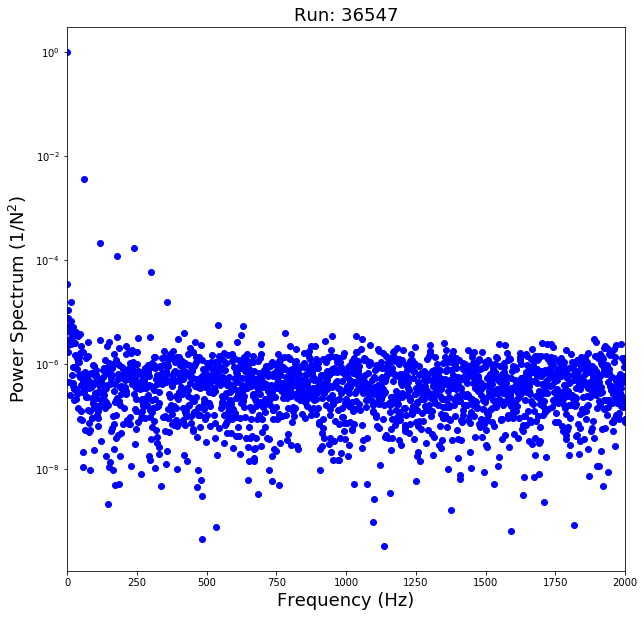

Run Number: 36548
2Theta angle: -0.01 (-0.01)
Number of events: 946865
Total exposure time (s): 906.9216225
Count rate: 1044.0428108769675


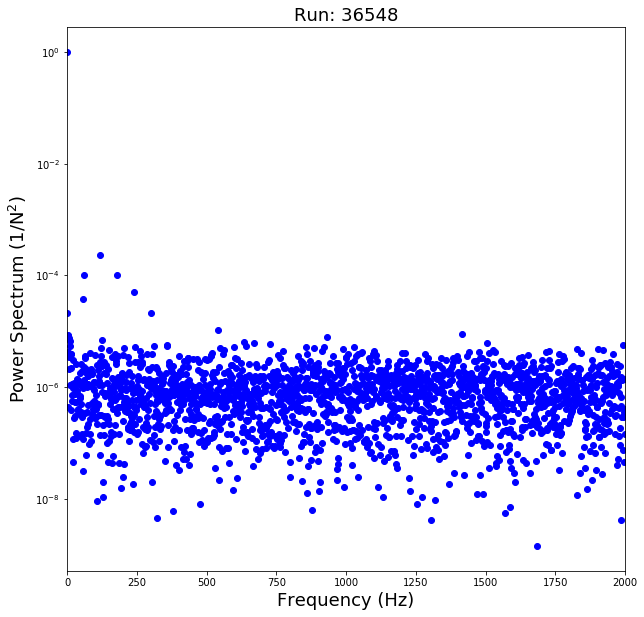

Run Number: 36556
2Theta angle: 0.81 (-0.01)
Number of events: 4475910
Total exposure time (s): 303.1029378
Count rate: 14766.96343653849


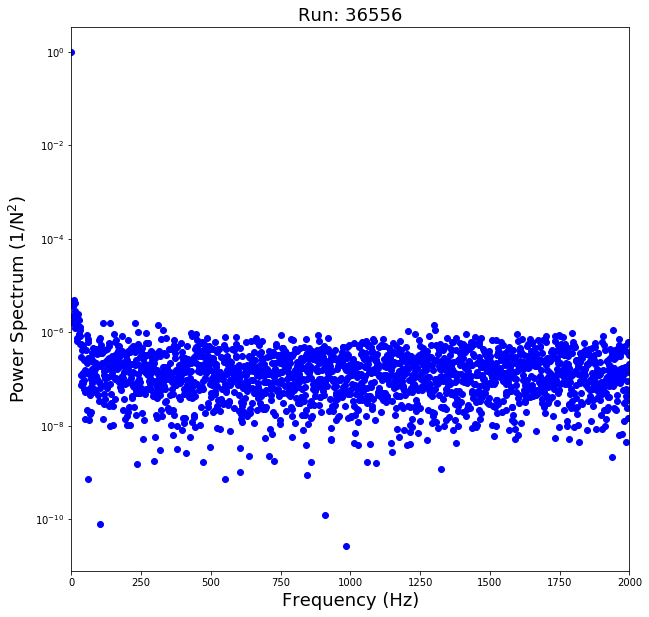

Run Number: 36557
2Theta angle: 1.21 (-0.01)
Number of events: 1714921
Total exposure time (s): 604.0027971000001
Count rate: 2839.2600303075646


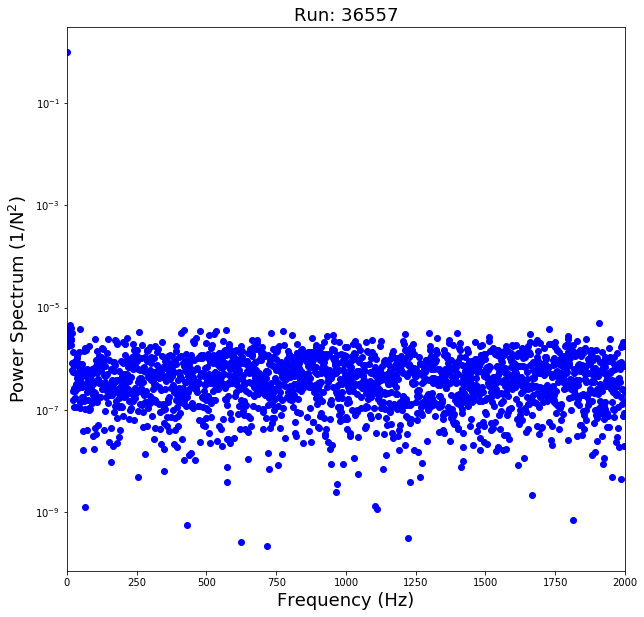

Run Number: 36558
2Theta angle: 1.86 (-0.01)
Number of events: 2404248
Total exposure time (s): 2740.4526781
Count rate: 877.3178311792284


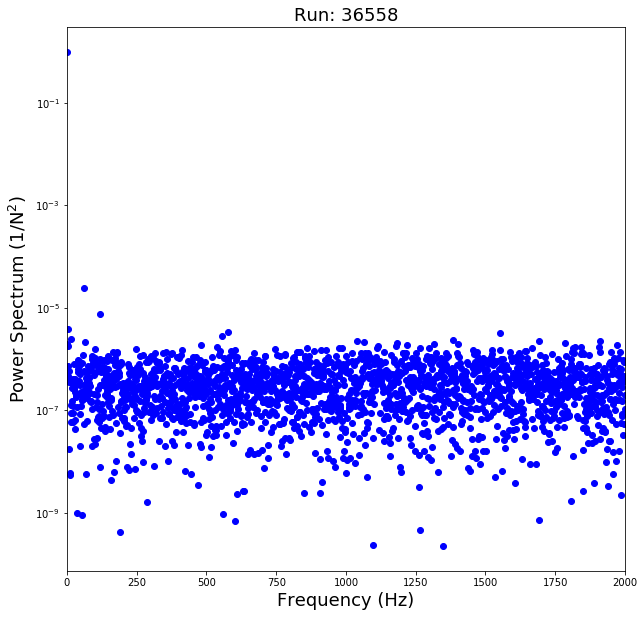

In [6]:
## This bit of code will check whether the user defined a range with the '-' symbol. If so create a continuous range of run numbers
if any('-' in s for s in run_numbers):
    i,j = int(run_numbers[0]),int(run_numbers[len(run_numbers)-1])
    if j<i:
        j,i = i,j
    run_numbers = []
    for k in range(i,j+1,1):
        run_numbers.append(str(k))
print('Run numbers to be processed:')
print(run_numbers)
MaxRunNumber = len(run_numbers)

for RunIndex in range(MaxRunNumber):
    
    Input_File_Base = directory_path+'input/'+run_numbers[RunIndex]+'_events_' 
    OutputFile = directory_path+run_numbers[RunIndex]+'_power.txt' 

# Check if file exists (unpolarized data file use Off_Off extension)
    data_is = os.path.isfile(Input_File_Base+'Off_Off'+'.npz') or os.path.isfile(Input_File_Base+'On_On'+'.npz')\
              or os.path.isfile(Input_File_Base+'On_Off'+'.npz') or os.path.isfile(Input_File_Base+'Off_On'+'.npz')

    if not data_is:
        print('Data files not found: %s'%Input_File_Base)
        raise SystemExit('Files not found, stopping.')
        
# Load some data
    all_data, all_log = load_some_data(Input_File_Base)

# map to variables
    active_spin_states = all_data[0]

    t0_time_Off_Off = all_data[1]
    t0_time_string_Off_Off = all_data[2]
    tof_Off_Off = all_data[3]
    pixel_id_Off_Off = all_data[4]
    pcharge_Off_Off = all_data[5]

    t0_time_On_Off = all_data[6]
    t0_time_string_On_Off = all_data[7]
    tof_On_Off = all_data[8]
    pixel_id_On_Off = all_data[9]
    pcharge_On_Off = all_data[10]

    t0_time_Off_On = all_data[11]
    t0_time_string_Off_On = all_data[12]
    tof_Off_On = all_data[13]
    pixel_id_Off_On = all_data[14]
    pcharge_Off_On = all_data[15]

    t0_time_On_On = all_data[16]
    t0_time_string_On_On = all_data[17]
    tof_On_On = all_data[18]
    pixel_id_On_On = all_data[19]
    pcharge_On_On = all_data[20]   

    pixel_to_coordinate= all_log[0]
    Source_Sample_Distance= all_log[1]
    Sample_Detector_Center_Distance= all_log[2]
    TemperatureLog_times= all_log[3]
    TemperatureLog_value= all_log[4]
    DANGLELog_times= all_log[5]
    DANGLELog_value= all_log[6]
    DANGLE0Log_times= all_log[7]
    DANGLE0Log_value= all_log[8]
    SANGLELog_times= all_log[9]
    SANGLELog_value= all_log[10]
    C0Log_times= all_log[11]
    C0Log_value= all_log[12]
    ChopperFreqLog_times= all_log[13]
    ChopperFreqLog_value= all_log[14]
    LambdaBarLog_times= all_log[15]
    LambdaBarLog_value= all_log[16]
    EMagLog_times= all_log[17]
    EMagLog_value= all_log[18]
    
    NEvents = np.uint64(len(tof_Off_Off)) 
           
    DeltaTime = t0_time_Off_Off - np.min(t0_time_Off_Off) # time in ns of a t0 pulse relative to the first one
    TOFns = np.uint64(tof_Off_Off * 1000) # tof of the event in ns
    RelativeTime = DeltaTime + TOFns # time in ns after first t0 of the event
    RelativeTime.sort()

    # calculate the power spectrum for events sampled at 1 ns, most have none.
    
    f = np.linspace(0, Maxf, fBins, dtype=np.float64)
    PowerSpectrum = np.zeros(fBins, dtype=np.float64)
    for k in range(fBins):
        FT = np.sum(np.exp(2*Pi*complex(0,1)*f[k]*RelativeTime*1e-9))
        PowerSpectrum[k] = np.float64((FT*FT.conjugate()).real)

    if Normalize:
        PowerSpectrum = PowerSpectrum / NEvents**2
        
    MaxTime = np.max(RelativeTime) * 1e-9 # Total counting time in s
    CountRate = NEvents / MaxTime
        
    print('Run Number: %s'%run_numbers[RunIndex])
    print('2Theta angle: %.2f (%.2f)'%(DANGLELog_value[0],DANGLE0Log_value[0]))  
    print('Number of events: %s'%NEvents)
    print('Total exposure time (s): %s'%MaxTime)
    print('Count rate: %s'%CountRate)
       
    # Plot the result

    plt.figure(figsize = (10,10))
    plt.title('Run: %s'%run_numbers[RunIndex], fontsize=18)
    if Normalize:
        plt.ylabel('Power Spectrum (1/N$^2$)', fontsize=18)
    else:
        plt.ylabel('Power Spectrum (Events$^2$)', fontsize=18)        
    plt.xlabel('Frequency (Hz)', fontsize=18)
    plt.xlim(0,np.max(f))
    plt.semilogy(f,PowerSpectrum,'bo')
    plt.show()

    # Write the result
    
    FileName = OutputFile
    OutStrings = []
    
    OutStrings.append('%.10e\t%.10e\t%s\t%.10e\n'%(f[0],PowerSpectrum[0],NEvents,CountRate))
    OFile = open(FileName, 'w')
    for item in OutStrings:
        OFile.write(item)
    OFile.close()    

    for k in np.arange(1,fBins,1):
        OutStrings.append('%.10e\t%.10e\n'%(f[k],PowerSpectrum[k]))
        OFile = open(FileName, 'w')
        for item in OutStrings:
            OFile.write(item)
        OFile.close()